# Face Mask Detection

### connecting colab with google drive

In [5]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [11]:
!ls "/content/drive/My Drive/Colab Notebooks/Face_mask_detector"

dataset  mask_detector.ipynb


### importing important libraries

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

### initialize the initial learning rate, number of epochs to train for, and batch size

In [ ]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [12]:
CATEGORIES = ["with_mask", "without_mask"]
DIRECTORY = "/content/drive/My Drive/Colab Notebooks/Face_mask_detector/dataset"

In [13]:
# storing image data and their names in two different lists data and labels respectively
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


### converting labels into binary format

In [15]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)


### converting list of data into array

In [16]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

### splitting dataset into training and testing dataset

In [17]:
trainX, testX, trainY, testY = train_test_split(data, labels,	test_size=0.20, stratify=labels, random_state=42)

### Constructing image generator using ImageDataGenerator function for data augmentation

In [20]:
aug = ImageDataGenerator(
                        rotation_range=20,
                        zoom_range=0.15,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.15,
                        horizontal_flip=True,
                        fill_mode="nearest"
                        )


### loading MobileNetV2 network excluding top layer

In [23]:
# here I am using pre trained weights values for image based model
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))


9420800/9406464 [==============================] - 0s 0us/step


### Designing top layer for baseModel

In [24]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


### making complete model by adding top layer on baseMode

In [25]:
model = Model(inputs=baseModel.input, outputs=headModel)


### freezing all layers in order to stop from being updated.

In [26]:
for layer in baseModel.layers:
	layer.trainable = False


### Compiling the model

In [27]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR // EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])




[INFO] compiling model...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [29]:
# train the head of the network

print("[INFO] training head...")
H = model.fit(
            aug.flow(trainX, trainY, batch_size=BS),
            steps_per_epoch=len(trainX) // BS,
            validation_data=(testX, testY),
            validation_steps=len(testX) // BS,
            epochs=EPOCHS
            )


95/95 [==============================] - 138s 1s/step - loss: 0.0357 - accuracy: 0.9901 - val_loss: 0.0294 - val_accuracy: 0.9857
Epoch 3/20
95/95 [==============================] - 142s 1s/step - loss: 0.0364 - accuracy: 0.9878 - val_loss: 0.0263 - val_accuracy: 0.9922
Epoch 4/20
95/95 [==============================] - 142s 1s/step - loss: 0.0297 - accuracy: 0.9901 - val_loss: 0.0245 - val_accuracy: 0.9909
Epoch 5/20
95/95 [==============================] - 140s 1s/step - loss: 0.0354 - accuracy: 0.9904 - val_loss: 0.0271 - val_accuracy: 0.9896
Epoch 6/20
95/95 [==============================] - 142s 1s/step - loss: 0.0288 - accuracy: 0.9918 - val_loss: 0.0228 - val_accuracy: 0.9909
Epoch 7/20
95/95 [==============================] - 140s 1s/step - loss: 0.0305 - accuracy: 0.9918 - val_loss: 0.0223 - val_accuracy: 0.9909
Epoch 8/20
95/95 [==============================] - 140s 1s/step - loss: 0.0262 - accuracy: 0.9931 - val_loss: 0.0213 - val_accuracy: 0.9909
Epoch 9/20
95/95 [======

### printing the prediction of testing dataset

In [30]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)


[INFO] evaluating network...


### Printing classification report

In [31]:
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,	target_names=lb.classes_))


              precision    recall  f1-score   support

   with_mask       1.00      0.99      0.99       383
without_mask       0.99      1.00      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



### plotting the training loss and accuracy for this model

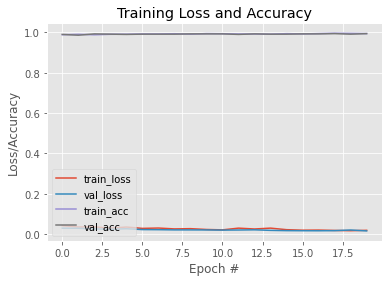

In [32]:

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

## Saving the model


In [34]:
print("[INFO] saving mask detector model...")
model.save("/content/drive/My Drive/Colab Notebooks/Face_mask_detection/mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
